# Statistical Analysis

Use various methods to answer the following questions:
* What factors are significantly related to the number of store purchases?
* Does US fare significantly better than the Rest of the World in terms of total purchases?
* Your supervisor insists that people who buy gold are more conservative. Therefore, people who spent an above average amount on gold in the last 2 years would have more in store purchases. Justify or refute this statement using an appropriate statistical test
* Fish has Omega 3 fatty acids which are good for the brain. Accordingly, do "Married PhD candidates" have a significant relation with amount spent on fish? What other factors are significantly related to amount spent on fish? (Hint: use your knowledge of interaction variables/effects)
* Is there a significant relationship between geographical regional and success of a campaign?

## Imports and Constants

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
import seaborn as sns
import scipy.stats as stats

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
DATA_PATH = '../data/'
DATA_FILE = 'marketing_data_clean.csv'

## Helper Functions

In [3]:
def df_ohe(data, col, prefix=''):
    """
    Create One Hot Encoded (OHE) features for a column and 
    return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    """
    dummies = pd.get_dummies(data[col],
                            prefix=prefix,
                            drop_first=True)
    data = data.drop(col, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [4]:
def make_category(data, col):
    """
    Make a dataframe column a category and perform a One Hot Encoding on it,
    and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    
    """
    suffix='_encoded'
    lb_make = LabelEncoder()
    data[col] = data[col].astype('category')
    data[col+suffix] = lb_make.fit_transform(data[col])
    data = data.drop(col, axis=1)
    data = df_ohe(data, col+suffix, col+'_')
    return data

## Read Data File

In [5]:
df = pd.read_csv(DATA_PATH + DATA_FILE, parse_dates=['Dt_Customer'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       2240 non-null   int64         
 1   Year_Birth               2240 non-null   int64         
 2   Education                2240 non-null   object        
 3   Marital_Status           2240 non-null   object        
 4   Income                   2216 non-null   object        
 5   Kidhome                  2240 non-null   int64         
 6   Teenhome                 2240 non-null   int64         
 7   Dt_Customer              2240 non-null   datetime64[ns]
 8   Recency                  2240 non-null   int64         
 9   MntWines                 2240 non-null   int64         
 10  MntFruits                2240 non-null   int64         
 11  MntMeatProducts          2240 non-null   int64         
 12  MntFishProducts          2240 non-

## What factors are significantly related to the number of store purchases?

### Prepare Data

In [7]:
fields_to_ignore = ['ID', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 
                    'Marital_Status_Group', 'marital_status_children', 
                    'income_q4', 'Income_Dollars', 'Dt_Customer']

In [8]:
X = df.drop(fields_to_ignore, axis=1)

In [9]:
y = df.NumStorePurchases

In [10]:
X = X.drop(['NumStorePurchases'], axis=1)

In [11]:
cat_fields = ['Education', 'Country', 'Marital_Status_Clean', 
              'any_children', 'income_q10']

In [12]:
for cat in cat_fields:
    X = make_category(X, cat)

### Check for Multicolinearity

Text(0.5, 1, 'Correlation Heatmap')

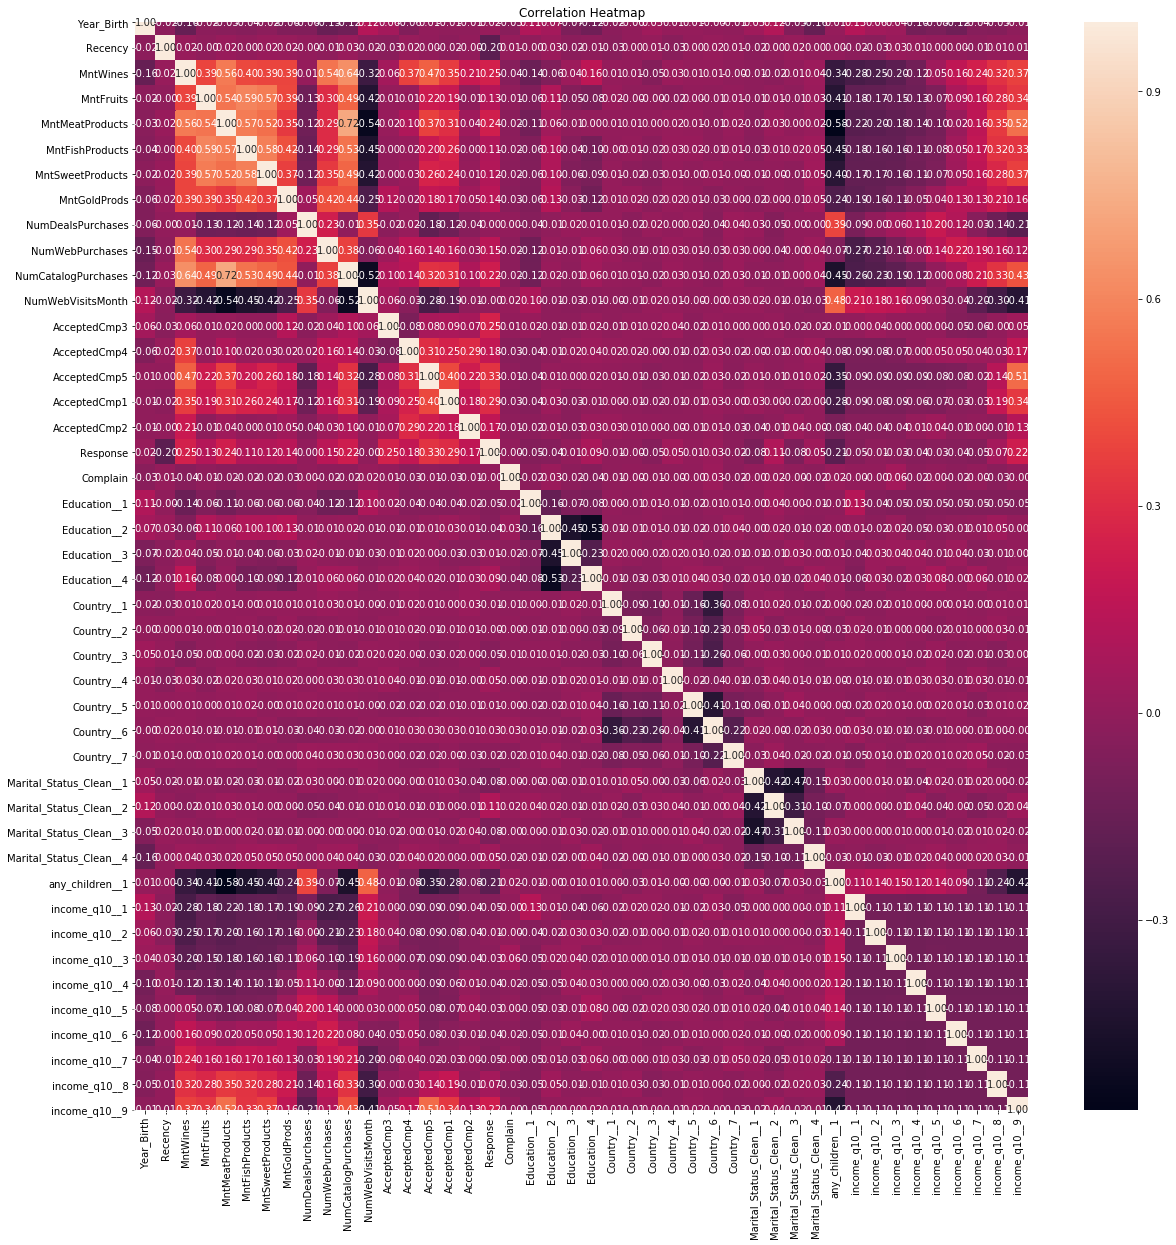

In [13]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(X.corr(), annot=True, fmt='.2f')
ax.set_title('Correlation Heatmap')

Drop NumCatalogPurchases because of multicoliniarity with MntMeatProducts and MntWines 

In [14]:
# drop because of multicoliniarity with NumCatalogPurchases
X.drop(['NumCatalogPurchases'], axis=1, inplace=True)

### Linear Regression

Because I am just just want to know feature importance, I will not be doing a train/test split.

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)

y_hat = lin_reg.predict(X)

mse = mean_squared_error(y, y_hat)

mae = mean_absolute_error(y, y_hat)

print(f'RMSE: {np.sqrt(mse)}')
print(f'')
print(f'MAE: {mae}')
print('')

mse_scorer = make_scorer(mean_squared_error)

cv_rmse = np.sqrt(np.mean(cross_val_score(lin_reg, X, 
                                                y, cv=10,
                                               scoring=mse_scorer)))
print(f'Cross Val RMSE: {cv_rmse}')

RMSE: 2.0388488705004133

MAE: 1.4616073721748015

Cross Val RMSE: 2.100931065914034


### Feature Importance

In [16]:
results = permutation_importance(lin_reg, X, y)

In [17]:
importance = list(zip(X.columns, results.importances_mean))

In [18]:
importance.sort(key = lambda x: x[1], reverse=True)

In [19]:
print('The top 10 most important factors determining NumStorePurchases')
print('')
for feature, score in importance[:10]:
    print(f'Feature: {feature}, Score: {round(score, 4)}')

The top 10 most important factors determining NumStorePurchases

Feature: MntWines, Score: 0.2184
Feature: income_q10__7, Score: 0.1239
Feature: income_q10__6, Score: 0.0996
Feature: income_q10__5, Score: 0.0663
Feature: income_q10__8, Score: 0.0587
Feature: income_q10__9, Score: 0.0551
Feature: NumWebVisitsMonth, Score: 0.0441
Feature: NumWebPurchases, Score: 0.0267
Feature: NumDealsPurchases, Score: 0.0261
Feature: MntFruits, Score: 0.0188


## Does US fare significantly better than the Rest of the World in terms of total purchases?

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ID                       2240 non-null   int64         
 1   Year_Birth               2240 non-null   int64         
 2   Education                2240 non-null   object        
 3   Marital_Status           2240 non-null   object        
 4   Income                   2216 non-null   object        
 5   Kidhome                  2240 non-null   int64         
 6   Teenhome                 2240 non-null   int64         
 7   Dt_Customer              2240 non-null   datetime64[ns]
 8   Recency                  2240 non-null   int64         
 9   MntWines                 2240 non-null   int64         
 10  MntFruits                2240 non-null   int64         
 11  MntMeatProducts          2240 non-null   int64         
 12  MntFishProducts          2240 non-

In [21]:
purchases_df = df[['Country', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']]

In [22]:
purchases_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']

In [23]:
purchases_df['total_purchases'] = df.loc[:, purchases_cols].sum(axis=1)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
purchases_df.drop(purchases_cols, axis=1, inplace=True)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
mean_total_purchases = purchases_df.total_purchases.mean()
print(f'The mean number of purchases for all customers is: {round(mean_total_purchases, 2)}')


The mean number of purchases for all customers is: 12.54


In [26]:
us_mean_tot_purch = purchases_df[purchases_df.Country == 'US'].total_purchases.mean()
print(f'The mean number of purchases for US customers is: {round(us_mean_tot_purch, 2)}')

The mean number of purchases for US customers is: 13.51


Is the US mean significantly different from the Population Mean?

define alpha = 0.05

H0 = there is no difference between the US and the rest of the world in regards to total purchases.

H1 = The US is doing better that the rest of the world

In [27]:
us_tot_purchases = purchases_df[purchases_df.Country == 'US'].total_purchases

Conduct a 1 Sample t-test comparing the population mean to the US mean

In [28]:
results = stats.ttest_1samp(us_tot_purchases, mean_total_purchases)

In [29]:
results

Ttest_1sampResult(statistic=1.43293588038269, pvalue=0.15476455427711802)

In [30]:
# one_sided_pvalue
results[1] / 2

0.07738227713855901

Because the p-value is greater than alpha, we fail to reject the null hypothesis, therefore we do not have evidence that US is doing significantly better than the rest of the world in regards to total number of purchases.

## Your supervisor insists that people who buy gold are more conservative. Therefore, people who spent an above average amount on gold in the last 2 years would have more in store purchases. Justify or refute this statement using an appropriate statistical test

In [34]:
gold_mean = df['MntGoldProds'].mean()

In [36]:
gold_mean_df = df[df.MntGoldProds > gold_mean]

In [45]:
gold_mean_df.NumStorePurchases.mean()

7.765129682997118

In [44]:
all_ave_store_purch = df.NumStorePurchases.mean()

In [43]:
all_ave_store_purch

5.790178571428571

H0 = There is no difference in the amount of store purchases

H1 = The above average gold purchasers have more in store purchases

alpha = 0.05

In [39]:
results = stats.ttest_1samp(gold_mean_df.NumStorePurchases, all_ave_store_purch)

In [40]:
results

Ttest_1sampResult(statistic=17.22739289930132, pvalue=1.261738070971042e-55)

In [41]:
# calculate the 1 sided p-value
results[1] / 2

6.30869035485521e-56

Given the extremely low p-value, we can reject the null hypothesis.  We have some evidence that customers that buy an above average amount of gold, make a significantly higher amount of store purchases.